# Verify the Conv-VAE sensorprocessing

Load a pre-trained model specified by an experiment/run trained by Train-Conv-VAE

This notebook runs a number of visualizations that allow to illustrate the performance of the trained encoding. The verification here primarily happens through visual observation. 

In [1]:
import sys
sys.path.append("..")
# adding the Julian-8897-Conv-VAE-PyTorch into the path

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

sys.path.append(Config()["conv_vae"]["code_dir"])
# from encoding_conv_vae.conv_vae import latest_json_and_model

from sensorprocessing import sp_conv_vae
from sensorprocessing import sp_helper
from sensorprocessing.sp_helper import get_transform_to_sp, load_picturefile_to_tensor

from demonstration.demonstration import Demonstration

import matplotlib.pyplot as plt
import pathlib
import random

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# At some point in the development, this hack was necessary for some reason. 
# It seems that as of Feb 2025, the code runs on Windows and Linux without it.
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
Using device: cuda


### Exp-run initialization
Create the exp/run-s that describe the parameters of the training. 
Some of the code here is structured in such a way as to make the notebook automatizable with papermill.

In [2]:
# *** Initialize the variables with default values 
# *** This cell should be tagged as parameters     
# *** If papermill is used, some of the values will be overwritten

experiment = "sensorprocessing_conv_vae"
# run = "sp_vae_256" 
run = "sp_vae_128" 

# If it is set to true, the exprun will be recreated from scratch
creation_style = "exist-ok"
# If not None, set an external experiment path
external_path = None

In [3]:
# create the necessary exp/run objects

if external_path:
    external_path = pathlib.Path(external_path)
    assert external_path.exists()
    Config().set_experiment_path(external_path)

# The experiment/run we are going to run: the specified model will be created
exp = Config().get_experiment(experiment, run, creation_style=creation_style)
print(exp)

***ExpRun**: Configuration for exp/run: sensorprocessing_conv_vae/sp_vae_128 successfully loaded
Experiment:
    class: ConvVaeSensorProcessing
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\sensorprocessing_conv_vae\sp_vae_128
    epochs: 5
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\sensorprocessing_conv_vae\sp_vae_128.yaml
    experiment_name: sensorprocessing_conv_vae
    image_size:
    - 64
    - 64
    json_template_name: conv-vae-config-default.json
    latent_size: 128
    model_dir: models
    model_name: VAE_Robot
    run_name: sp_vae_128
    save_period: 5
    subrun_name: null
    training_data:
    - - random-both-cameras-video
      - '2025_03_08__14_15_53'
      - dev2
    - - random-both-cameras-video
      - '2025_03_08__14_16_57'
      - dev2
    - - random-both-cameras-video
      - '2025_03_08__14_19_12'
      - dev2
    - - random-both-cameras-video
      - '2025_03_08__

## Verify the Conv-VAE by visual reconstruction
We can verify a Conv-VAE model visually based on its ability to recover the input image from the encoding. The intuition here would be that information that is lost during the recovery is not present in the encoding, and thus it won't be usable by the algorithms using this encoding either.

In [11]:
sp = sp_conv_vae.ConvVaeSensorProcessing(exp, device)
transform = get_transform_to_sp(exp)
demos = []
cameras = []
# load the demonstrations specified in the experiment validation data
for val in exp["validation_data"]:
    run, demo_name, camera = val
    exp_demo = Config().get_experiment("demonstration", run)
    demo = Demonstration(exp_demo, demo_name)
    demos.append(demo)
    cameras.append(camera)

# Choose n pictures from the validation set and store them in lists of images and imagefiles
n = 6
demo = demos[0]
camera = cameras[0]
images_processable = []
images_display = []
#imagefiles = []
for i in range(demo.metadata["maxsteps"]):
    rnd = random.randint(0, demo.metadata["maxsteps"] - 1)
    #imagefiles.append(demo.get_image_path(rnd))
    image_processable, image_display = demo.get_image(rnd, device=device, camera=camera, transform=transform)
    images_processable.append(image_processable)
    images_display.append(image_display)


***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_defaults_demonstration.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: demonstration/random-both-cameras-video successfully loaded
***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_defaults_demonstration.yaml was empty, ok.
***ExpRun**: Configuration for exp/run: demonstration/random-both-cameras-video successfully loaded


In [13]:
# Verify whether the sp can process the images from the file
# This is turned off, because most demonstrations will be in video 
# so no independent picture files
transform = get_transform_to_sp(exp)
for image in images_processable:
    # sensor_readings, _ = load_picturefile_to_tensor(imagefile, transform, device)
    output = sp.process(image)
    print(output)

[-1.25458255e-01 -1.07360780e+00 -4.90469635e-01 -3.53366286e-01
 -8.51566792e-02  4.33894247e-01 -1.54587364e+00 -1.03874457e+00
  3.13923687e-01 -4.67799045e-03  5.87385930e-02  8.23943615e-02
  1.59477025e-01  1.64058059e-04 -4.45342138e-02 -2.45220438e-01
  1.00420046e+00  3.65131199e-01 -1.20506704e+00  8.62250090e-01
  4.05485630e-01 -5.75219035e-01  3.29311252e-01  1.19539171e-01
 -1.13608372e+00 -6.85224682e-03  7.62782693e-02 -3.20062786e-01
  1.16708474e-02  1.69896281e+00 -2.80747145e-01 -1.79123178e-01
  1.43184030e+00  2.03883260e-01  4.27410871e-01  1.33164155e+00
  2.42703125e-01 -1.22499421e-01  1.17817454e-01  1.14605956e-01
 -6.43943772e-02 -6.07821941e-01  2.18032062e-01  1.47420824e-01
  5.14848113e-01 -6.00272059e-01 -2.11881742e-01 -3.40116583e-03
  4.33966815e-01 -1.04089057e+00 -1.86288506e-01  9.62644696e-01
 -3.31133604e-02 -2.17374057e-01  2.93282300e-01 -2.33443286e-02
 -1.63455093e+00  3.48588377e-01  9.41625774e-01 -1.17287934e-02
 -2.32852906e-01  3.97713

In [14]:
# Verify whether we can process the images loaded from the demonstration
for image in images_processable:
    z = sp.process(image)
    print(f"The encoding is\n {z}")

The encoding is
 [-1.25458255e-01 -1.07360780e+00 -4.90469635e-01 -3.53366286e-01
 -8.51566792e-02  4.33894247e-01 -1.54587364e+00 -1.03874457e+00
  3.13923687e-01 -4.67799045e-03  5.87385930e-02  8.23943615e-02
  1.59477025e-01  1.64058059e-04 -4.45342138e-02 -2.45220438e-01
  1.00420046e+00  3.65131199e-01 -1.20506704e+00  8.62250090e-01
  4.05485630e-01 -5.75219035e-01  3.29311252e-01  1.19539171e-01
 -1.13608372e+00 -6.85224682e-03  7.62782693e-02 -3.20062786e-01
  1.16708474e-02  1.69896281e+00 -2.80747145e-01 -1.79123178e-01
  1.43184030e+00  2.03883260e-01  4.27410871e-01  1.33164155e+00
  2.42703125e-01 -1.22499421e-01  1.17817454e-01  1.14605956e-01
 -6.43943772e-02 -6.07821941e-01  2.18032062e-01  1.47420824e-01
  5.14848113e-01 -6.00272059e-01 -2.11881742e-01 -3.40116583e-03
  4.33966815e-01 -1.04089057e+00 -1.86288506e-01  9.62644696e-01
 -3.31133604e-02 -2.17374057e-01  2.93282300e-01 -2.33443286e-02
 -1.63455093e+00  3.48588377e-01  9.41625774e-01 -1.17287934e-02
 -2.3285

# Visualize the VAE reconstruction

In [24]:
def visualize_VAE(sp, exp, device, image, axoriginal, axreconstr):
    """Helper function to show the original and the reconstruction in fields of a picture."""
    # transform = sp_helper.get_transform_to_sp(exp)
    #input, image = sp_helper.load_picturefile_to_tensor(picture_name, transform, device=device)
    # Running the input on the output
    output, mu, logvar = sp.model(image)
    # Output: the visual reconstruction
    original = image[0].cpu().permute(1, 2, 0).detach().numpy()
    output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()
    # Showing the input and the reconstruction    
    #axoriginal.imshow(image.to("cpu").numpy()[0][0])
    axoriginal.imshow(original)
    axoriginal.set_title("Original")
    axreconstr.imshow(output_for_pic)
    axreconstr.set_title("Reconstruct")
    return output, mu, logvar

Pictures0
mu=tensor([[-1.2546e-01, -1.0736e+00, -4.9047e-01, -3.5337e-01, -8.5157e-02,
          4.3389e-01, -1.5459e+00, -1.0387e+00,  3.1392e-01, -4.6780e-03,
          5.8739e-02,  8.2394e-02,  1.5948e-01,  1.6406e-04, -4.4534e-02,
         -2.4522e-01,  1.0042e+00,  3.6513e-01, -1.2051e+00,  8.6225e-01,
          4.0549e-01, -5.7522e-01,  3.2931e-01,  1.1954e-01, -1.1361e+00,
         -6.8522e-03,  7.6278e-02, -3.2006e-01,  1.1671e-02,  1.6990e+00,
         -2.8075e-01, -1.7912e-01,  1.4318e+00,  2.0388e-01,  4.2741e-01,
          1.3316e+00,  2.4270e-01, -1.2250e-01,  1.1782e-01,  1.1461e-01,
         -6.4394e-02, -6.0782e-01,  2.1803e-01,  1.4742e-01,  5.1485e-01,
         -6.0027e-01, -2.1188e-01, -3.4012e-03,  4.3397e-01, -1.0409e+00,
         -1.8629e-01,  9.6264e-01, -3.3113e-02, -2.1737e-01,  2.9328e-01,
         -2.3344e-02, -1.6346e+00,  3.4859e-01,  9.4163e-01, -1.1729e-02,
         -2.3285e-01,  3.9771e-02, -5.1917e-02,  3.4715e-01,  1.8868e-01,
          1.4293e+00, -1.

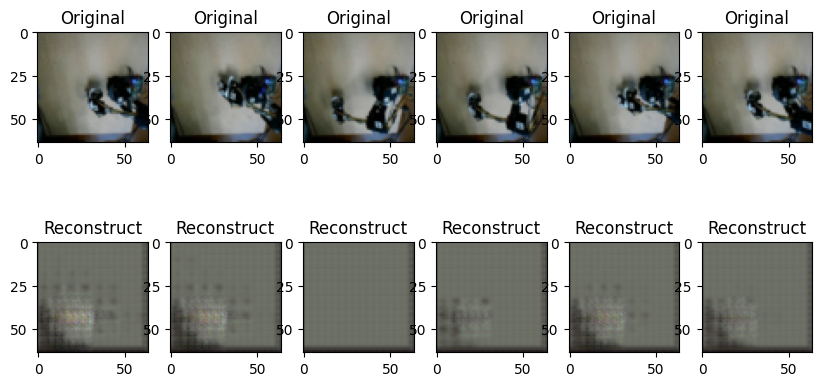

In [25]:
# This cell visualizes the original and reconstructed pictures by going inside 
# the sensorprocessing object and accessing the model
fig, axs = plt.subplots(2, n, figsize=(10, 5))
for i in range(n):
    output, mu, logvar = visualize_VAE(sp, exp, device, images_processable[i], axs[0,i], axs[1,i])
    print(f"Pictures{i}\nmu={mu}\nlogvar={logvar}")

fig_reconstructed_path = pathlib.Path(exp.data_dir(), "orig_reconstr.pdf")
fig.savefig(fig_reconstructed_path, bbox_inches='tight')


## Reconstruction from noisy latent encoding


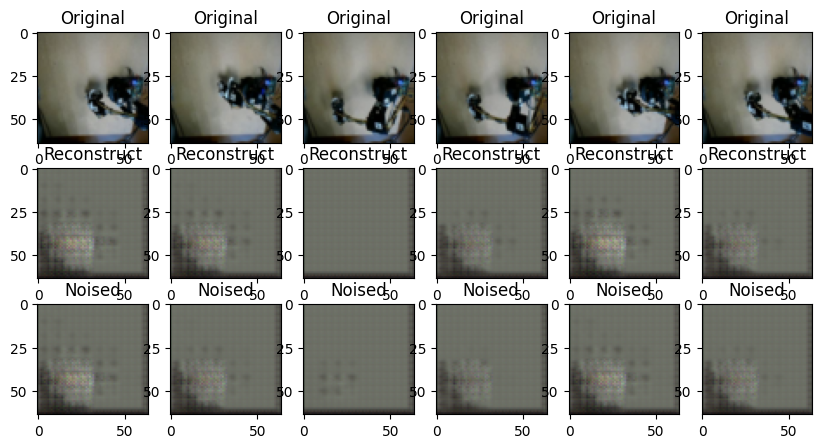

In [27]:
fig, axs = plt.subplots(3, n, figsize=(10, 5))
for i in range(n):
    output, mu, logvar = visualize_VAE(sp, exp, device, images_processable[i], axs[0,i], axs[1,i])
    # print(f"Pictures{i}\nmu={mu}\nlogvar={logvar}")
    # this samples a new z with its logvar
    z2 = sp.model.reparameterize(mu, logvar)
    # adding some noise to the encoding (FIXME: add random noise)
    for j in range(exp["latent_size"]):
        z2[0][j] = z2[0][j] + 0.001
    #output2 = sp.model.decode(z2)
    output2 = sp.model.decode(mu)
    output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()
    axs[2,i].imshow(output_for_pic2)
    axs[2,i].set_title("Noised")

fig_reconstruction_from_noisy_path = pathlib.Path(exp.data_dir(), "reconstr_from_noisy.pdf")
fig.savefig(fig_reconstruction_from_noisy_path, bbox_inches='tight')


# Generating random samples from the model

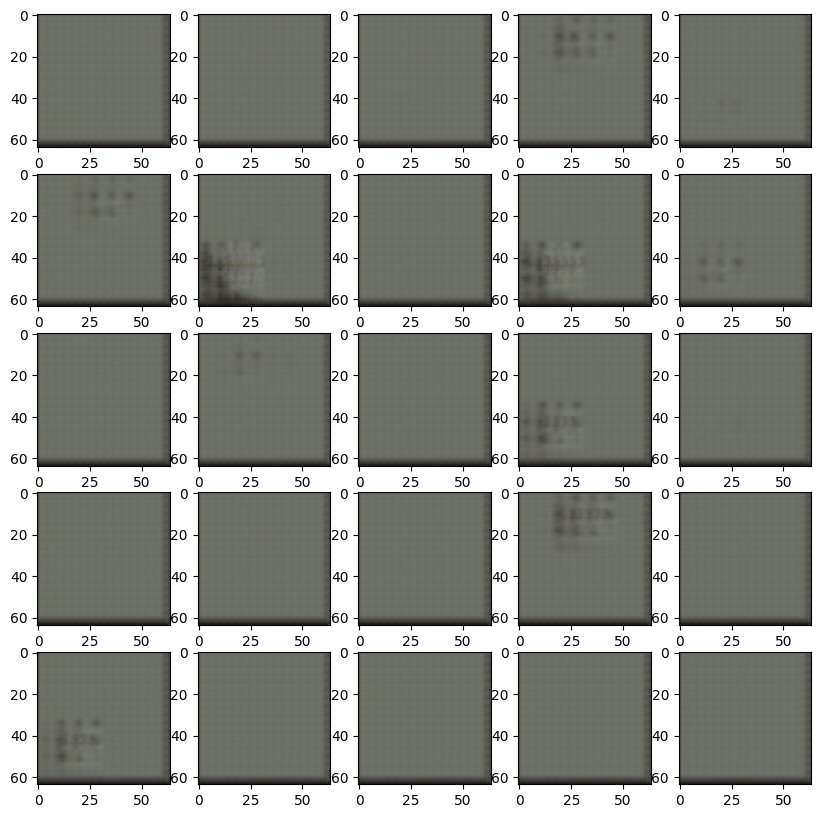

In [28]:

# this can be actually done by just calling sp.model.sample!
samples = sp.model.sample(num_samples = 25, current_device=device)
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
i = 0
for x in range(0, 5):
    for y in range(0, 5):
        output_for_pic = samples[i].cpu().permute(1, 2, 0).detach().numpy()
        axs[x][y].imshow(output_for_pic)
        i += 1

fig_random_samples = pathlib.Path(exp.data_dir(), "random_samples.pdf")
fig.savefig(fig_random_samples, bbox_inches='tight')
